
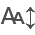

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

from matplotlib_venn import venn2

import matplotlib.patches as mpatches

import pandas as pd
import numpy as np

from scipy.stats import pearsonr 
from joblib import Parallel, delayed

# import urllib.request
import fastobo
import json

import goatools
from goatools.obo_parser import GODag

import itables.options as opt
from itables import init_notebook_mode, show
from itables.downsample import as_nbytes, nbytes
from itables.sample_dfs import get_indicators

init_notebook_mode(all_interactive=False)
opt.maxBytes = "128KB"

import seaborn as sns

sns.set()
plt.style.use('default')
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, BoundaryNorm

import matplotlib.cm as cm
import matplotlib.colors as mcolors

from collections import Counter

import glob
import inspect

import igraph as ig
from community import community_louvain as com
import random

import os

In [7]:
def abrir_txt(nombre_archivo):
    archivo=open(nombre_archivo)
    data=[]
    for linea in archivo:
        linea=linea.strip()
        columna=linea.split()
        data.append(columna)
    return data

def gigante(G):
	componentes = nx.connected_components(G)
	componentes = list(componentes)
	componentes.sort(key=len, reverse=True)
	componente_gigante = G.subgraph(componentes[0])
	return componente_gigante

In [8]:
cota = 0.9
adyacencia = pd.read_csv('../../Datos/transcriptomas/Matrices_javi/matriz_pearson_breeden_adyacencia-'+str(cota)+'.csv')
adyacencia = adyacencia.set_index('Proteina')
adyacencia_sin_diagonal = adyacencia.copy()
np.fill_diagonal(adyacencia_sin_diagonal.values, 0)

In [9]:
def assign_edge_colors(G):
    edge_colors = {2: 'plum',
        -2: 'lightseagreen'}

    nx.set_edge_attributes(G, {e: edge_colors.get(G[e[0]][e[1]]['weight'], 'black') for e in G.edges()}, 'color')

In [11]:
#Le doy a todo
G = nx.from_pandas_adjacency(adyacencia_sin_diagonal)

# Asignar colores a las aristas
assign_edge_colors(G)

In [12]:
G2 = G.copy()

for u, v, data in G2.edges(data=True):
    if data['weight'] == -2.0 or data['weight'] == 2.0:
        data['weight'] = 1.0

In [13]:
# Ahora voy a probar armando 2 subgrafos, uno con las aristas de color rojo y otro con las aristas de color azul

G_positiva = G.copy()
G_negativa = G.copy()

for u, v, data in G.edges(data=True):
	if data['weight'] == -2.0:
		G_positiva.remove_edge(u, v)
	elif data['weight'] == 2.0:
		G_negativa.remove_edge(u, v)
                
#Cambio a peso 1 las aristas que quedaron
for u, v, data in G_positiva.edges(data=True):
	if data['weight'] == 2.0:
		data['weight'] = 1.0

for u, v, data in G_negativa.edges(data=True):
	if data['weight'] == -2.0:
		data['weight'] = 1.0

In [14]:
G_positiva.number_of_edges(), G_negativa.number_of_edges(), G.number_of_edges()

(11972, 2387, 14359)

In [52]:
# nx.write_gml(G, 'red_pesada-0.9-sinY2H.gml')

In [15]:
interacciones_y2h = abrir_txt('../../Datos/Y2HNueva.csv')
interacciones_y2h = [elem[0].split(',') for elem in interacciones_y2h]
interacciones_y2h[:10]

[['YAL001C', 'YBR123C'],
 ['YAL001C', 'YDR362C'],
 ['YAL001C', 'YDR381W'],
 ['YAL001C', 'YGR047C'],
 ['YAL001C', 'YOR110W'],
 ['YAL007C', 'YAR002C-A'],
 ['YAL007C', 'YBL003C'],
 ['YAL007C', 'YBR009C'],
 ['YAL007C', 'YDR086C'],
 ['YAL007C', 'YDR174W']]

In [16]:
y2h = nx.Graph()
y2h.add_edges_from(interacciones_y2h)

y2h.number_of_edges(), y2h.number_of_nodes()
# nx.write_gpickle(y2h, 'y2h.gpickle')

(14318, 3673)

In [17]:
nodos_en_G = [node for node in y2h.nodes if node in G]
cantidad_nodos_en_G = len(nodos_en_G)
cantidad_nodos_en_G

3631

In [18]:
red_pesada_y2h = nx.Graph()

for u, v in y2h.edges():
    red_pesada_y2h.add_edge(u, v, weight=1)

for u, v in G_positiva.edges():
    if red_pesada_y2h.has_edge(u, v):
        red_pesada_y2h[u][v]['weight'] += 1
    else:
        # Si un enlace está en `G_positiva` pero no en `y2h`, se agrega con peso 0.3
        red_pesada_y2h.add_edge(u, v, weight=0.3)

for u, v in G_negativa.edges():
    if red_pesada_y2h.has_edge(u, v):
        red_pesada_y2h[u][v]['weight'] -= 0.5
    else:
        # Si un enlace está solo en `G_negativa`, se agrega con peso 0.1
        red_pesada_y2h.add_edge(u, v, weight=0.1)

print("Número de nodos en la red pesada:", red_pesada_y2h.number_of_nodes())
print("Número de enlaces en la red pesada:", red_pesada_y2h.number_of_edges())

# Filtrar enlaces con pesos negativos o nulos en caso de que los haya
enlaces_a_remover = [(u, v) for u, v, data in red_pesada_y2h.edges(data=True) if data['weight'] <= 0]
red_pesada_y2h.remove_edges_from(enlaces_a_remover)

print("Red final:")
print("Número de nodos:", red_pesada_y2h.number_of_nodes())

Número de nodos en la red pesada: 4610
Número de enlaces en la red pesada: 28613
Red final:
Número de nodos: 4610


In [19]:
# Obtener pesos de los enlaces
pesos = [data['weight'] for _, _, data in red_pesada_y2h.edges(data=True)]

# Definir los colores según el peso
def asignar_color(peso, colores_tuple):
	if peso == 1:
		return colores_tuple[0]
	elif peso == 2:
		return colores_tuple[1]
	elif peso == 0.5:
		return colores_tuple[2]
	else:
		return 'red'  # Opcional, para pesos no especificados
	
def asignar_colores_full(peso, colores_tuple):
	if peso == 1:
		return colores_tuple[0]
	elif peso == 2:
		return colores_tuple[1]
	elif peso == 0.5:
		return colores_tuple[2]
	elif peso == 0.3:
		return colores_tuple[3]
	elif peso == 0.1:
		return colores_tuple[4]
	else:
		return 'red'  # Opcional, para pesos no especificados
	
# Asignar colores basados en los pesos
colores = [asignar_color(p, colores_tuple = ('white', 'plum', 'lightseagreen')) for p in pesos]

In [20]:
def edge_colors_funcion(red_pesada, colores_tuple = ('white', 'plum', 'lightseagreen')):
    # Obtener pesos de los enlaces
	pesos = [data['weight'] for _, _, data in red_pesada.edges(data=True)]

	# Asignar colores basados en los pesos
	if len(colores_tuple) == 3:
		colores = [asignar_color(p, colores_tuple) for p in pesos]
	else:
		colores = [asignar_colores_full(p, colores_tuple) for p in pesos]

	return colores

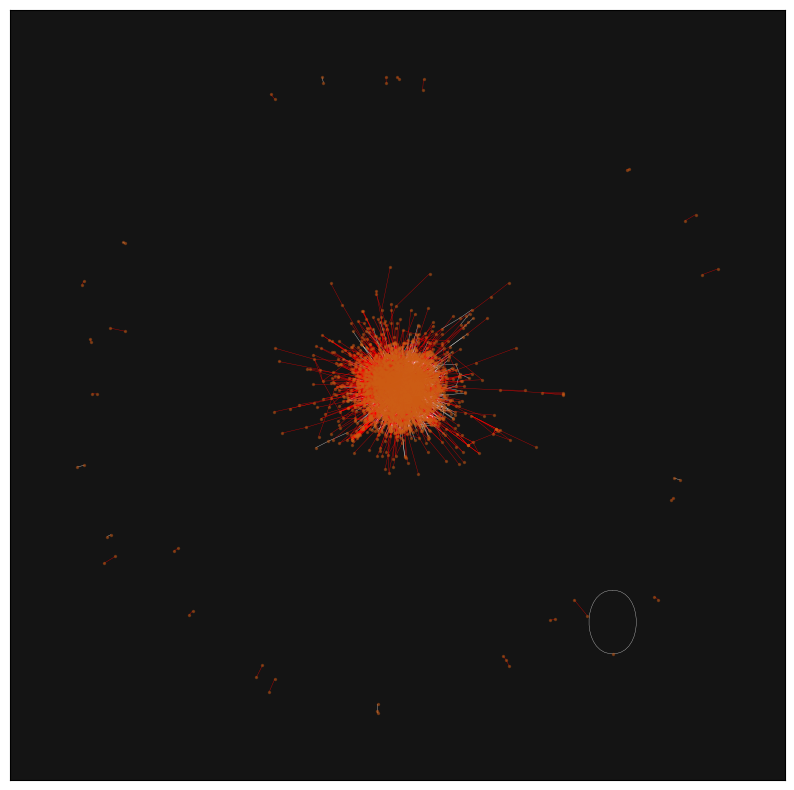

In [ ]:
# Dibujar el grafo
pos_layout = nx.spring_layout(red_pesada_y2h)  # Layout para la posición de los nodos
edges = red_pesada_y2h.edges(data=True)

fig, axes = plt.subplots(1, 1, figsize = (10,10))

for i, ax in enumerate(fig.axes):
	pos = nx.spring_layout(red_pesada_y2h, seed=42)
	ax.set_facecolor('#141414') 
	nx.draw_networkx_nodes(red_pesada_y2h,
						   pos = pos_layout,
						   node_color = '#cc5c14',
						   ax = ax,
						   node_size = 2, alpha = 0.4)
	
	nx.draw_networkx_edges(red_pesada_y2h, pos = pos_layout, ax = ax, alpha = .7, edge_color = colores, width = 0.3)

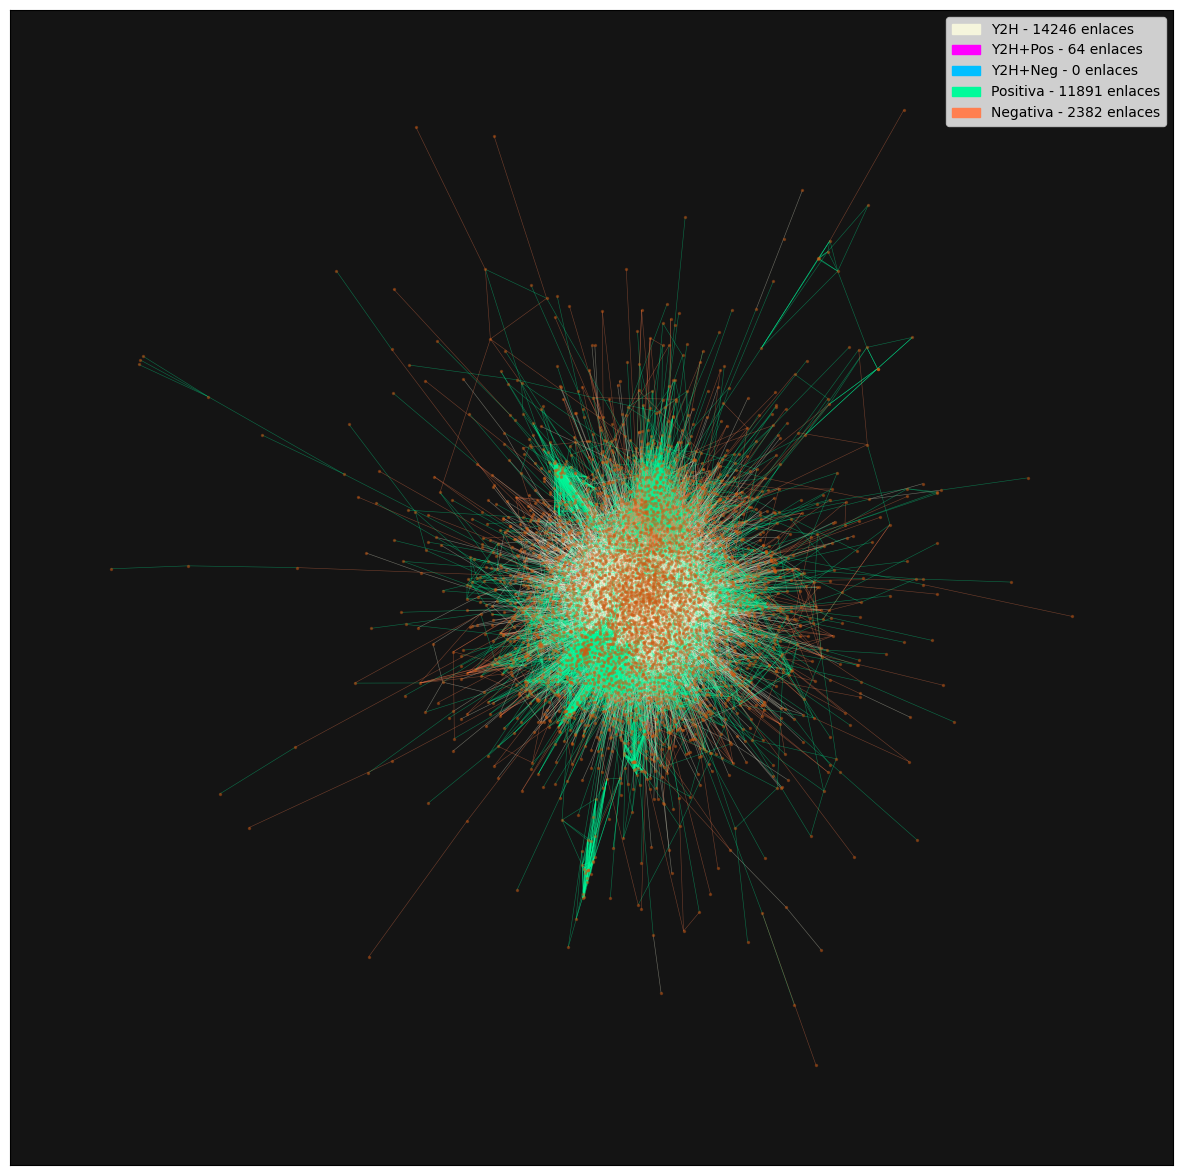

In [39]:
gigante_red_pesada = gigante(red_pesada_y2h)

edges = gigante_red_pesada.edges(data=True)

colores_tuple = ('beige', 'magenta', 'deepskyblue', 'mediumspringgreen', 'coral')

colores = edge_colors_funcion(gigante_red_pesada, colores_tuple = colores_tuple)
conteo = Counter(colores)
conteo


pos_layout = nx.spring_layout(gigante_red_pesada, seed=42)  # Layout para la posición de los nodos

fig, axes = plt.subplots(1, 1, figsize = (15,15))

for i, ax in enumerate(fig.axes):
	pos = nx.spring_layout(gigante_red_pesada, seed=42)
	ax.set_facecolor('#141414') 
	nx.draw_networkx_nodes(gigante_red_pesada,
						   pos = pos_layout,
						   node_color = '#cc5c14',
						   ax = ax,
						   node_size = 2, alpha = 0.4)
	
	nx.draw_networkx_edges(gigante_red_pesada, pos = pos_layout, ax = ax, alpha = .4, edge_color = colores, width = 0.4)

if len(colores_tuple) == 5:
	plt.legend(handles=[mpatches.Patch(color=colores_tuple[0], label='Y2H - ' + str(conteo[colores_tuple[0]]) + ' enlaces'), 
						mpatches.Patch(color=colores_tuple[1], label='Y2H+Pos - ' + str(conteo[colores_tuple[1]]) + ' enlaces'), 
						mpatches.Patch(color=colores_tuple[2], label='Y2H+Neg - ' + str(conteo[colores_tuple[2]]) + ' enlaces'),
						mpatches.Patch(color=colores_tuple[3], label='Positiva - ' + str(conteo[colores_tuple[3]]) + ' enlaces'),
						mpatches.Patch(color=colores_tuple[4], label='Negativa - ' + str(conteo[colores_tuple[4]]) + ' enlaces')], loc='upper right')
else:
	plt.legend(handles=[mpatches.Patch(color=colores_tuple[0], label='Y2H - ' + str(conteo[colores_tuple[0]]) + ' enlaces'), 
						mpatches.Patch(color=colores_tuple[1], label='Y2H+Pos - ' + str(conteo[colores_tuple[1]]) + ' enlaces'), 
						mpatches.Patch(color=colores_tuple[2], label='Y2H+Neg - ' + str(conteo[colores_tuple[2]]) + ' enlaces')], loc='upper right')

In [ ]:
# nx.write_gpickle(red_pesada_y2h, 'red_pesada_y2h-cota09+full.gpickle')

## Analizo como en histogramas

In [21]:
# Funciones para abrir archivos:

def abrir_txt(nombre_archivo):
    archivo=open(nombre_archivo)
    data=[]
    for linea in archivo:
        linea=linea.strip()
        columna=linea.split()
        data.append(columna)
    return data

def abrir_esenciales(nombre_archivo):
    archivo = open(nombre_archivo)
    data = []
    for linea in archivo:
        linea=linea.strip()
        columna=linea.split()
        data.append(columna)
    data = data[2:]
    esenciales = []
    for linea in data:
      if len(linea)>2:
        esenciales.append(linea[1])
    return(esenciales)

In [22]:
#Colores para enlaces
def assign_edge_colors(G):
    edge_colors = {2: 'plum',
        -2: 'lightseagreen'}

    nx.set_edge_attributes(G, {e: edge_colors.get(G[e[0]][e[1]]['weight'], 'black') for e in G.edges()}, 'color')

def asignar_color(peso, colores_tuple):
	if peso == 1:
		return colores_tuple[0]
	elif peso == 2:
		return colores_tuple[1]
	elif peso == 0.5:
		return colores_tuple[2]
	else:
		return 'gray'  # Opcional, para pesos no especificados
	
def asignar_colores_full(peso, colores_tuple):
	if peso == 1:
		return colores_tuple[0]
	elif peso == 2:
		return colores_tuple[1]
	elif peso == 0.5:
		return colores_tuple[2]
	elif peso == 0.3:
		return colores_tuple[3]
	elif peso == 0.1:
		return colores_tuple[4]
	else:
		return 'gray'  # Opcional, para pesos no especificados
	
def edge_colors_funcion(red_pesada, colores_tuple = ('white', 'plum', 'lightseagreen')):
    # Obtener pesos de los enlaces
	pesos = [data['weight'] for _, _, data in red_pesada.edges(data=True)]

	# Asignar colores basados en los pesos
	if len(colores_tuple) == 3:
		colores = [asignar_color(p, colores_tuple) for p in pesos]
	else:
		colores = [asignar_colores_full(p, colores_tuple) for p in pesos]

	return colores

In [23]:
# Funciones para análisis de redes

def aplicar_louivan(red, resolucion = 1):# Louivan
	com_lv = com.best_partition(red, weight='weight', resolution = resolucion)

	print(f'La cantidad de comunas que maximiza la modularidad es: {max(com_lv.values()) + 1}')
	print(f'La modularidad de dicha partición es: {com.modularity(com_lv, red)}')

	return com_lv

def guardar_louivan(red, path, resolucion = 1):
	partition = aplicar_louivan(red, resolucion = resolucion)

	comunidades = {}
	for nodo, comunidad in partition.items():
		if comunidad not in comunidades:
			comunidades[comunidad] = []
		comunidades[comunidad].append(nodo)

	subgrafos = {}
	for comunidad, nodos in comunidades.items():
		subgrafo = red.subgraph(nodos).copy()
		subgrafos[comunidad] = subgrafo

		ruta = path+f"subgrafo_comunidad_{comunidad}.graphml"
		if not os.path.exists(path):
			os.makedirs(path)

		nx.write_graphml(subgrafo, ruta)

In [24]:
def gigante(G):
	componentes = nx.connected_components(G)
	componentes = list(componentes)
	componentes.sort(key=len, reverse=True)
	componente_gigante = G.subgraph(componentes[0])
	return componente_gigante

def armar_componente_gigante(Red):
  Conjunto_nodos_en_gigante = max(nx.connected_components(Red), key=len)
  Componente_Gigante = Red.subgraph(Conjunto_nodos_en_gigante).copy()
  return Componente_Gigante

def elementos_tabla(Red):
	# Me quedo solo con la componente gigante
	Red_gigante = armar_componente_gigante(Red)

	nodos = Red_gigante.number_of_nodes()
	enlaces = Red_gigante.number_of_edges()
	promedio_grados = np.mean([grado for (nodo,grado) in list(Red_gigante.degree())])
	clustering = nx.average_clustering(Red_gigante)
	
	return (nodos,enlaces,promedio_grados,clustering)

In [165]:
def centralidad_nodos(Red):
    
	diccionario_grado = dict(Red.degree())
	diccionario_cercania = nx.closeness_centrality(Red, u=None, distance='weight', wf_improved=True)
	diccionario_betweenness = nx.betweenness_centrality(Red, weight='weight')
	diccionario_autovalor = nx.eigenvector_centrality(Red, max_iter=5000, tol=1e-06, nstart=None, weight='weight')
	
	return diccionario_grado, diccionario_cercania, diccionario_betweenness, diccionario_autovalor

def armar_tabla_centralidad(Red):

	diccionario_grado, diccionario_cercania, diccionario_betweenness, diccionario_autovalor = centralidad_nodos(Red)

	tabla = pd.DataFrame(columns = ['Nodo', 'Grado', 'Cercanía', 'Betweenness', 'Autovalor'])
	for nodo in Red.nodes():
		df = pd.DataFrame({'Nodo' : nodo, 'Grado' : diccionario_grado[nodo], 'Cercanía' : diccionario_cercania[nodo], 
						   'Betweenness' : diccionario_betweenness[nodo], 'Autovalor' : diccionario_autovalor[nodo]}, index=[0])
		tabla = pd.concat([tabla, df])
	tabla = tabla.reset_index(drop=True)
	return tabla

def porcentaje_mayor_valores(tabla, centralidad, porcentaje):
	tabla_ordenada = tabla.sort_values(by = [centralidad], ascending = False)
	
	tabla_ordenada = tabla_ordenada.reset_index(drop=True)
	cantidad = int(len(tabla_ordenada)*porcentaje)

	return tabla_ordenada[['Nodo', centralidad]][:cantidad]

def porcentaje_mayor_valores_javi(tabla, centralidad, porcentaje):
	tabla_ordenada = tabla.sort_values(by = [centralidad], ascending = False)
	numeros_ordenados = tabla_ordenada[centralidad]
	valor_cota = max(numeros_ordenados) - ((max(numeros_ordenados) - min(numeros_ordenados))*porcentaje)
	# print(valor_cota)
	tt = tabla_ordenada[tabla_ordenada[centralidad] >= valor_cota].copy()
	
	return tt[['Nodo', centralidad]]

def calcular_accuracy(tabla, lista_esenciales, porcentaje, calcular_porcentaje = 'standard'):
	keys = ['Grado', 'Cercanía', 'Betweenness', 'Autovalor']
	accuracy = {keys[0]:[], keys[1]:[], keys[2]:[], keys[3]:[]}

	for centralidad in keys:
		
		if calcular_porcentaje == 'standard':
			tabla_porcentaje = porcentaje_mayor_valores(tabla, centralidad, porcentaje)
		elif calcular_porcentaje == 'javi':
			tabla_porcentaje = porcentaje_mayor_valores_javi(tabla, centralidad, porcentaje)

		nodos_en_tabla = set(tabla_porcentaje['Nodo'])
		esenciales_en_tabla = [nodo for nodo in nodos_en_tabla if nodo in lista_esenciales]

		cantidad_escenciales = len(lista_esenciales)
	
		exactitud = len(esenciales_en_tabla)/cantidad_escenciales * 100
		accuracy[centralidad] = exactitud
		
	return accuracy

def calcular_accuracy_precision(tabla, lista_esenciales, porcentaje, calcular_porcentaje = 'standard'):
	keys = ['Grado', 'Cercanía', 'Betweenness', 'Autovalor']
	accuracy = {keys[0]:[], keys[1]:[], keys[2]:[], keys[3]:[]}
	precision = {keys[0]:[], keys[1]:[], keys[2]:[], keys[3]:[]}

	for centralidad in keys:
		
		if calcular_porcentaje == 'standard':
			tabla_porcentaje = porcentaje_mayor_valores(tabla, centralidad, porcentaje)
		elif calcular_porcentaje == 'javi':
			tabla_porcentaje = porcentaje_mayor_valores_javi(tabla, centralidad, porcentaje)

		nodos_en_tabla = set(tabla_porcentaje['Nodo'])
		esenciales_en_tabla = [nodo for nodo in nodos_en_tabla if nodo in lista_esenciales]

		cantidad_escenciales = len(lista_esenciales)
	
		exactitud = len(esenciales_en_tabla)/cantidad_escenciales * 100
		accuracy[centralidad] = exactitud

		precision[centralidad] = len(esenciales_en_tabla)/len(nodos_en_tabla) * 100
		
	return accuracy, precision

In [154]:
Data_esenciales = abrir_txt('../TP3/TC03_data/Essential_ORFs_paperHe.txt')
print(Data_esenciales)

lista_esenciales_repetidos = abrir_esenciales('../TP3/TC03_data/Essential_ORFs_paperHe.txt')
lista_esenciales = list(set(lista_esenciales_repetidos))
print (lista_esenciales)

[['rec_num', 'ORF_name', 'deletion_alias', 'gene_names', 'UPTAG_sequence_20mer', 'DNTAG_sequence_20mer'], ['=====', '=========', '==============', '=====================================================', '====================', '===================='], ['20406', 'YAL001C', 'TSV115,', 'FUN24', 'ACTATATGTGAAGGCATGGC'], ['20404', 'YAL003W', 'TEF5', 'GACATATCAGCATACATGGC'], ['20383', 'YAL025C', 'TGCCGCATCAAAGAGGCCAA'], ['20376', 'YAL032C', 'FUN20', 'TGATCCGCGTCGATGCTCTT'], ['20375', 'YAL033W', 'FUN53', 'CTGACTTAGTGCATACTGCT'], ['20372', 'YAL034W-a', 'NSL2,', 'DSN3', 'GGACCTCTGCTCATTATGCT'], ['20373', 'YAL035C-A', 'ATTGGTCACTCTGCACTGCT'], ['20368', 'YAL038W', 'PYK1', 'ATTGAGAGTCAGTGCCAGAT'], ['20365', 'YAL041W', 'CLS4', 'TATGGACTGGCATCACCGTG'], ['20362', 'YAL043C', 'FUN39', 'AGTCCATGCAGCACTCTTGG'], ['20409', 'YAR007C', 'RPA1,', 'FUN3,', 'BUF2', 'GCAGTGCGTGAACCTCTATC'], ['20410', 'YAR008W', 'FUN4', 'CATGAGAGTGAAGCAGTATC'], ['20416', 'YAR019C', 'LYT1', 'GCGCTTATCACATTTGACAG'], ['23028', 'YBL0

In [168]:
def funcion_analisis(archivo, path, resolucion = 1, porcentaje = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5], metodo_porcentaje = 'standard', comp_gigante = False):

	if comp_gigante == False:
		red_pesada = nx.read_gpickle(archivo)
		red_evaluar = red_pesada
	elif comp_gigante == True:
		red_pesada = nx.read_gpickle(archivo)
		red_evaluar = gigante(red_pesada)

	guardar_louivan(red_evaluar, path, resolucion=resolucion)

	tabla1 = pd.DataFrame(columns = ['Comunidad', 'Nodos', 'Enlaces', 'Grado promedio', 'Coeficiente de clustering'])
	grafitos = sorted(list(glob.glob(path+'*.graphml')))

	grafitos_ordenados = sorted(grafitos, key=lambda x: int(x.split('_comunidad_')[1].split('.')[0]))

	for grafo in grafitos_ordenados:
		red = nx.read_graphml(grafo)
		nodos, enlaces, promedio_grados, clustering = elementos_tabla(red)
		
		name = grafo.split('_comunidad_')[1].split('.')[0]

		df = pd.DataFrame({'Comunidad' : name, 'Nodos' : nodos, 'Enlaces' : enlaces, 
											'Grado promedio' : promedio_grados, 'Coeficiente de clustering' : clustering}, index=[0])
		tabla1 = pd.concat([tabla1, df])

	tabla1 = tabla1.reset_index(drop=True)

	tabla_centralidades = pd.DataFrame(columns = ['Nodo', 'Grado', 'Cercanía', 'Betweenness', 'Autovalor'])

	for grafo in grafitos_ordenados:
		Red = nx.read_graphml(grafo)
		tabla_aux = armar_tabla_centralidad(Red)
		tabla_centralidades = pd.concat([tabla_centralidades, tabla_aux])
		tabla_centralidades = tabla_centralidades.reset_index(drop=True)

	

	accuracy_df = pd.DataFrame(columns = ['Porcentaje', 'Grado', 'Cercanía', 'Betweenness', 'Autovalor'])
	precision_df = pd.DataFrame(columns = ['Porcentaje', 'Grado', 'Cercanía', 'Betweenness', 'Autovalor'])

	for porc in porcentaje:
		accuracy, precision = calcular_accuracy_precision(tabla_centralidades, lista_esenciales, porc, calcular_porcentaje = metodo_porcentaje)
		df = pd.DataFrame({'Porcentaje' : str(int(porc*100))+'%', 'Grado' : accuracy['Grado'], 'Cercanía' : accuracy['Cercanía'], 
						'Betweenness' : accuracy['Betweenness'], 'Autovalor' : accuracy['Autovalor']}, index=[0])
		accuracy_df = pd.concat([accuracy_df, df])

		df2 = pd.DataFrame({'Porcentaje' : str(int(porc*100))+'%', 'Grado' : precision['Grado'], 'Cercanía' : precision['Cercanía'], 
						'Betweenness' : precision['Betweenness'], 'Autovalor' : precision['Autovalor']}, index=[0])
		precision_df = pd.concat([precision_df, df2])

	accuracy_df = accuracy_df.reset_index(drop=True)
	precision_df = precision_df.reset_index(drop=True)

	return tabla1, tabla_centralidades, accuracy_df, precision_df

In [221]:
# porcentaje = np.arange(0.05, 1, 0.05)
porcentaje = np.arange(0.05, 0.2, 0.05)
metodo = 'standard'

lista_archivo = ['red_pesada_y2h-cota06.gpickle', 'red_pesada_y2h-cota09+full.gpickle', 'red_pesada-0.9-sinAPMS.gpickle', 'y2h.gpickle']
lista_path = ['06entera/', '09full/', '09siny2h/', 'y2h/']

lista_tabla1, lista_tabla_centralidades, lista_accuracy_df, lista_precision = [], [], [], []

for i in range(len(lista_archivo)):
	print('Analizando archivo: ', lista_archivo[i][:-8])
	archivo = lista_archivo[i]
	path = '../../Datos/subgrafos/y2h/'+metodo+'/'+lista_path[i]
	tabla1, tabla_centralidades, accuracy_df, precision_df = funcion_analisis(archivo, path, resolucion = 1, porcentaje=porcentaje, metodo_porcentaje = metodo, comp_gigante = False)
	lista_tabla1.append(tabla1)
	lista_tabla_centralidades.append(tabla_centralidades)
	lista_accuracy_df.append(accuracy_df)
	lista_precision.append(precision_df)

lista_accuracy_df[0]['Categoría'] = 'Y2H + C(0.6)'
lista_accuracy_df[1]['Categoría'] = 'Y2H + C(0.9)plus'
lista_accuracy_df[2]['Categoría'] = 'C(0.9)'
lista_accuracy_df[3]['Categoría'] = 'Y2H'

lista_precision[0]['Categoría'] = 'Y2H + C(0.6)'
lista_precision[1]['Categoría'] = 'Y2H + C(0.9)plus'
lista_precision[2]['Categoría'] = 'C(0.9)'
lista_precision[3]['Categoría'] = 'Y2H'

df_final = pd.concat([lista_accuracy_df[0], lista_accuracy_df[1], lista_accuracy_df[2], lista_accuracy_df[3]], ignore_index=True)
df_final = df_final[['Categoría', 'Porcentaje', 'Grado', 'Cercanía', 'Betweenness', 'Autovalor']]

df_final2 = pd.concat([lista_precision[0], lista_precision[1], lista_precision[2], lista_precision[3]], ignore_index=True)
df_final2 = df_final2[['Categoría', 'Porcentaje', 'Grado', 'Cercanía', 'Betweenness', 'Autovalor']]

categorias = df_final['Categoría'].unique()
porcentajes = df_final['Porcentaje'].unique()

metricas = ['Grado', 'Cercanía', 'Betweenness', 'Autovalor']



Analizando archivo:  red_pesada_y2h-cota06
La cantidad de comunas que maximiza la modularidad es: 41
La modularidad de dicha partición es: 0.5255143822538171
Analizando archivo:  red_pesada_y2h-cota09+full
La cantidad de comunas que maximiza la modularidad es: 58
La modularidad de dicha partición es: 0.5377217959344505
Analizando archivo:  red_pesada-0.9-sinAPMS
La cantidad de comunas que maximiza la modularidad es: 4124
La modularidad de dicha partición es: 0.8038448021090725
Analizando archivo:  y2h
La cantidad de comunas que maximiza la modularidad es: 40
La modularidad de dicha partición es: 0.5097140425621753


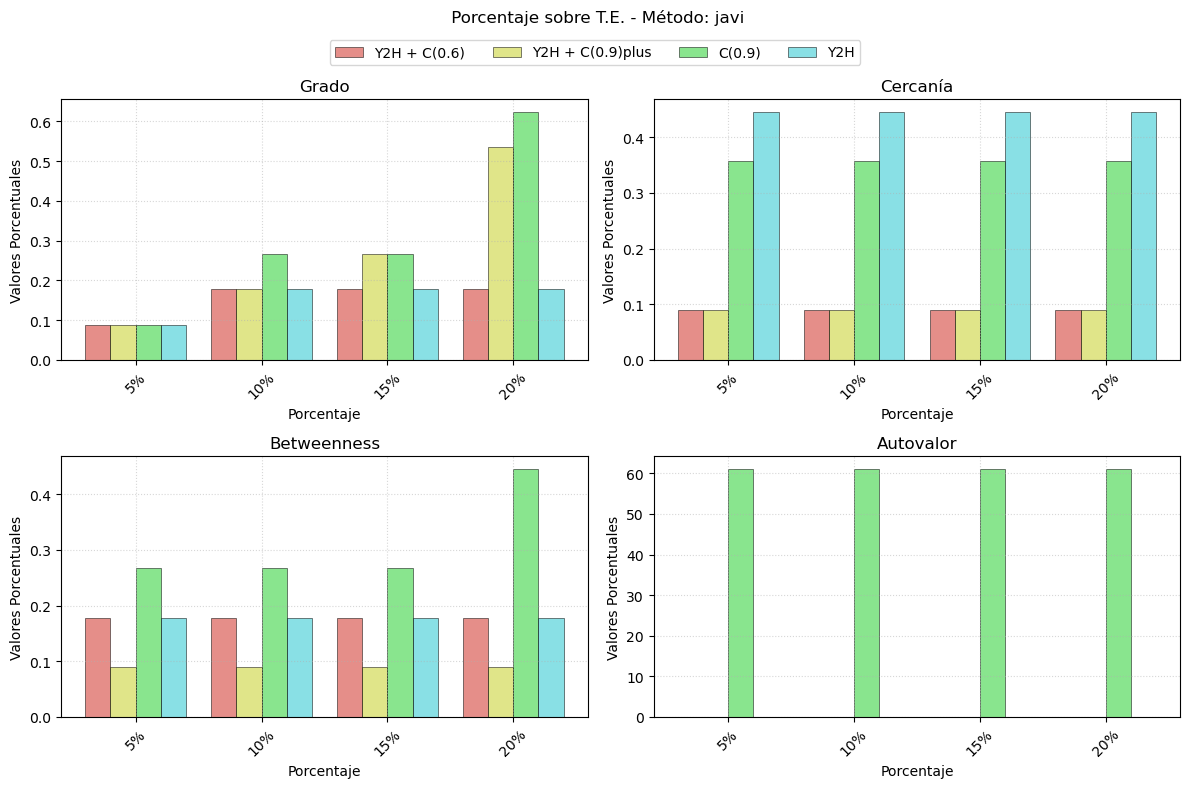

In [214]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))  

cantidad_porcentajes = 10  # Elegir cuántos porcentajes graficar 
porcentajes_seleccionados = porcentajes[:cantidad_porcentajes] 
x_posiciones = np.arange(len(porcentajes_seleccionados))
ancho_barra = 0.2


for k, metrica in enumerate(metricas):
    fila = k // 2
    columna = k % 2
    eje = ax[fila, columna]
    
    for i, categoria in enumerate(categorias):
        df_categoria = df_final[
            (df_final['Categoría'] == categoria) & 
            (df_final['Porcentaje'].isin(porcentajes_seleccionados))
        ]
        
        eje.bar(x_posiciones + i * ancho_barra, df_categoria[metrica].values, 
            width=ancho_barra, label=categoria, alpha=0.7, edgecolor='black', linewidth=0.5, color=sns.color_palette('hls')[i])
    
    eje.set_xticks(x_posiciones + (len(categorias) - 1) * ancho_barra / 2)
    eje.set_xticklabels(porcentajes_seleccionados, rotation=45)
    eje.set_xlabel('Porcentaje')
    eje.set_ylabel('Valores Porcentuales')
    eje.set_title(metrica)
    eje.grid(True, ls='dotted', alpha=0.5)

handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=len(categorias))

fig.suptitle(' Porcentaje sobre T.E. - Método: ' +  metodo)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar el layout para evitar solapamientos

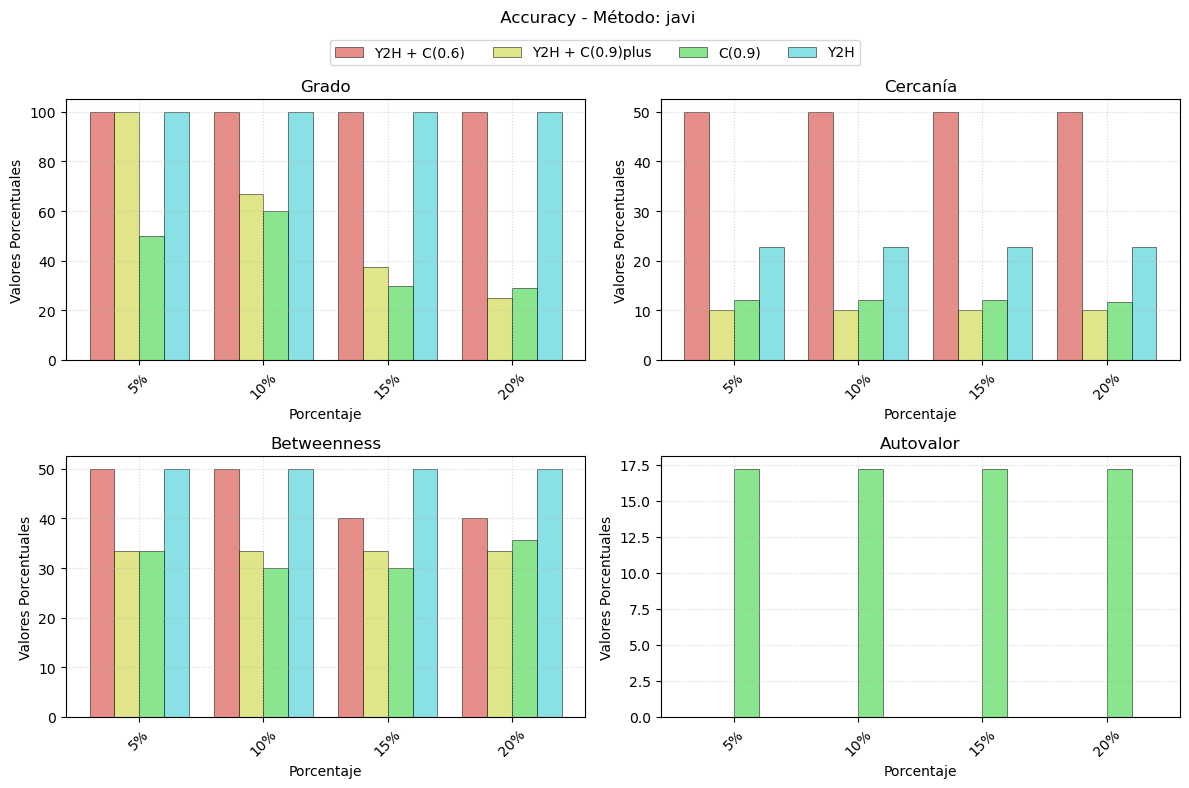

In [215]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))  

cantidad_porcentajes = 10  # Elegir cuántos porcentajes graficar 
porcentajes_seleccionados = porcentajes[:cantidad_porcentajes] 
x_posiciones = np.arange(len(porcentajes_seleccionados))
ancho_barra = 0.2


for k, metrica in enumerate(metricas):
    fila = k // 2
    columna = k % 2
    eje = ax[fila, columna]
    
    for i, categoria in enumerate(categorias):
        df_categoria = df_final2[
            (df_final2['Categoría'] == categoria) & 
            (df_final2['Porcentaje'].isin(porcentajes_seleccionados))
        ]
        
        eje.bar(x_posiciones + i * ancho_barra, df_categoria[metrica].values, 
            width=ancho_barra, label=categoria, alpha=0.7, edgecolor='black', linewidth=0.5, color=sns.color_palette('hls')[i])
    
    eje.set_xticks(x_posiciones + (len(categorias) - 1) * ancho_barra / 2)
    eje.set_xticklabels(porcentajes_seleccionados, rotation=45)
    eje.set_xlabel('Porcentaje')
    eje.set_ylabel('Valores Porcentuales')
    eje.set_title(metrica)
    eje.grid(True, ls='dotted', alpha=0.5)

handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=len(categorias))

fig.suptitle(' Accuracy - Método: ' +  metodo)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar el layout para evitar solapamientos

Red 06: y2h + correlacion con cota 0.6  Valores: 0.5, 1, 2
Red 09+full: y2h + correlacion con cota 0.9 + enlances solo de correlacion  Valores: 0.1, 0.3, 0.5, 1, 2
Red 09 sin Y2H: red de correlacion - Valores: 0.5, 1
Red Y2H: red de interacciones Y2H - Valores_ 1

#### VENN

In [217]:
def calcular_accuracy_javi(tabla, lista_esenciales, porcentaje, calcular_porcentaje = 'standard'):
	keys = ['Grado', 'Cercanía', 'Betweenness', 'Autovalor']
	accuracy = {keys[0]:[], keys[1]:[], keys[2]:[], keys[3]:[]}
	
	tabla_porcentaje_salida = {}
	esenciales_en_tabla_salida = {}

	for centralidad in keys:
		
		if calcular_porcentaje == 'standard':
			tabla_porcentaje = porcentaje_mayor_valores(tabla, centralidad, porcentaje)
		elif calcular_porcentaje == 'javi':
			tabla_porcentaje = porcentaje_mayor_valores_javi(tabla, centralidad, porcentaje)

		nodos_en_tabla = set(tabla_porcentaje['Nodo'])
		esenciales_en_tabla = [nodo for nodo in nodos_en_tabla if nodo in lista_esenciales]

		cantidad_escenciales = len(lista_esenciales)
	
		exactitud = len(esenciales_en_tabla)/cantidad_escenciales * 100
		accuracy[centralidad] = exactitud
		
		tabla_porcentaje_salida[centralidad] = tabla_porcentaje
		esenciales_en_tabla_salida[centralidad] = esenciales_en_tabla
		
	# tabla_porcentaje_salida = pd.DataFrame.from_dict(tabla_porcentaje_salida, orient='index')
	return accuracy, tabla_porcentaje_salida, esenciales_en_tabla_salida

In [269]:
# porcentaje = np.arange(0.05, 1, 0.05)
porcentaje = np.arange(0.05, 0.2, 0.05)

# lista_archivo = ['red_pesada_y2h-cota06.gpickle', 'red_pesada_y2h-cota09+full.gpickle', 'red_pesada-0.9-sinAPMS.gpickle', 'y2h.gpickle']
# lista_path = ['06entera/', '09full/', '09siny2h/', 'y2h/']

lista_archivo = ['red_pesada-cota06.gpickle', 'red_pesada-cota09+full.gpickle', 'red_pesada-0.9-sinAPMS.gpickle', 'apms.gpickle']
lista_path = ['06entera/', '09full/', '09sinapms/', 'apms/']

lista_tabla1, lista_tabla_centralidades = [], []

for i in range(len(lista_archivo)):
	print('Analizando archivo: ', lista_archivo[i][:-8])
	archivo = lista_archivo[i]
	path = '../../Datos/subgrafos/apms/'+metodo+'/'+lista_path[i]
	tabla1, tabla_centralidades, accuracy_df, precision_df = funcion_analisis(archivo, path, resolucion = 1, porcentaje=porcentaje, metodo_porcentaje = metodo, comp_gigante = False)
	lista_tabla1.append(tabla1)
	lista_tabla_centralidades.append(tabla_centralidades)



Analizando archivo:  red_pesada-cota06
La cantidad de comunas que maximiza la modularidad es: 214
La modularidad de dicha partición es: 0.789007262748976
Analizando archivo:  red_pesada-cota09+full
La cantidad de comunas que maximiza la modularidad es: 179
La modularidad de dicha partición es: 0.7998241736693958
Analizando archivo:  red_pesada-0.9-sinAPMS
La cantidad de comunas que maximiza la modularidad es: 4124
La modularidad de dicha partición es: 0.8066209526116243
Analizando archivo:  apms
La cantidad de comunas que maximiza la modularidad es: 213
La modularidad de dicha partición es: 0.7910016544115372


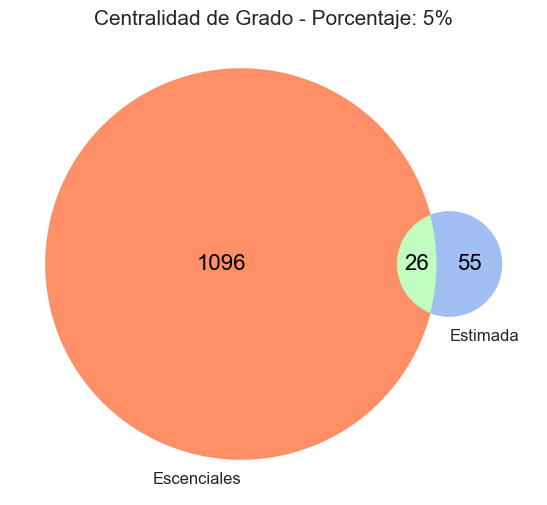

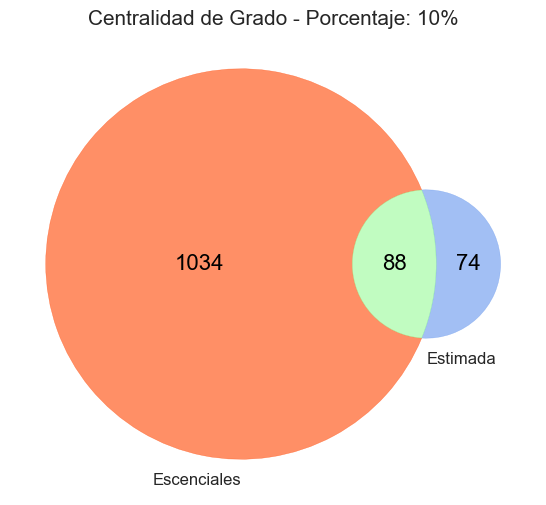

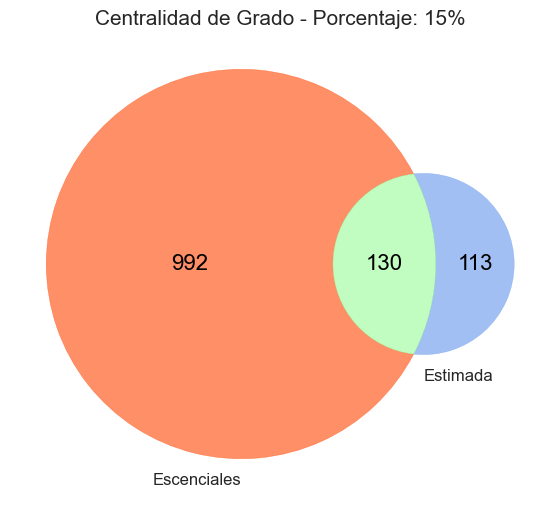

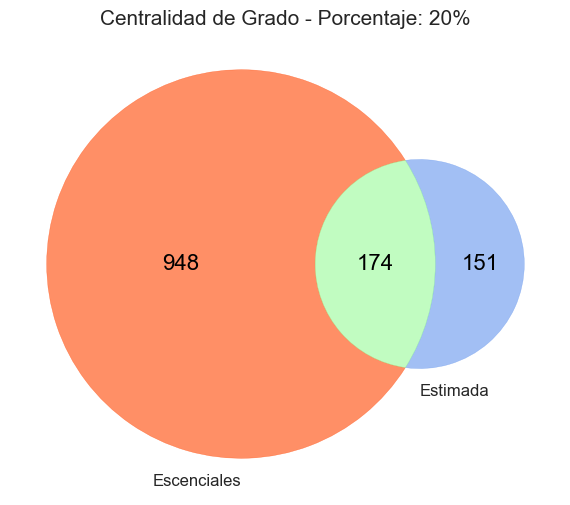

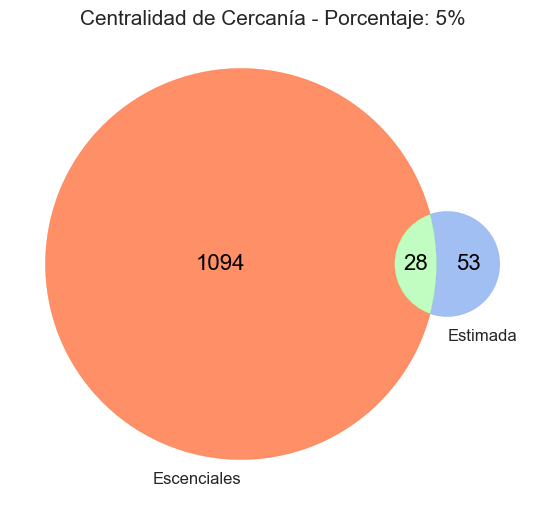

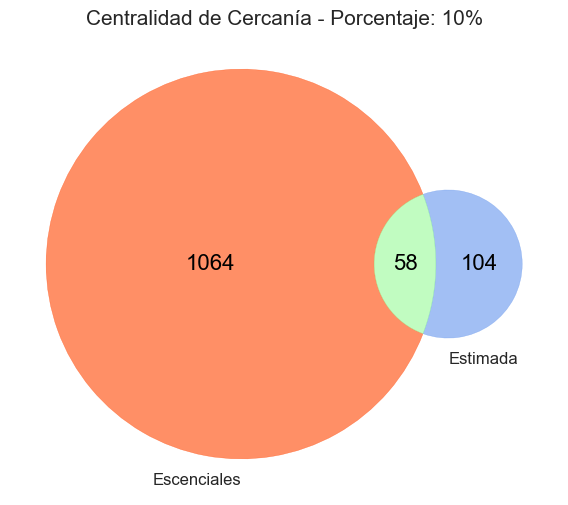

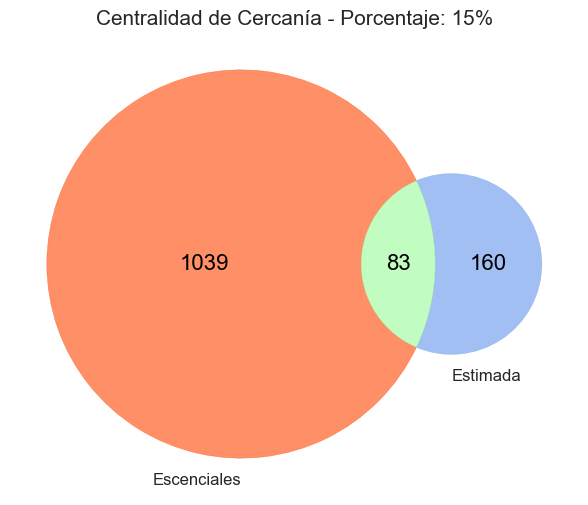

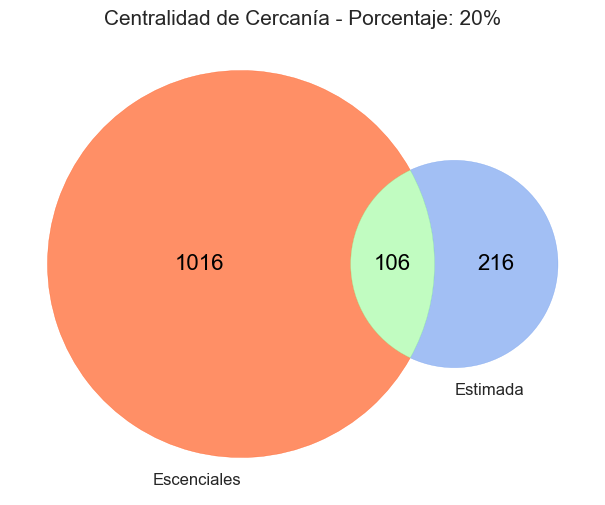

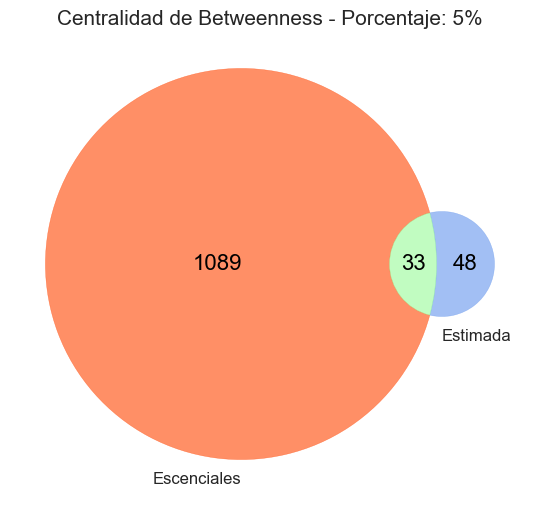

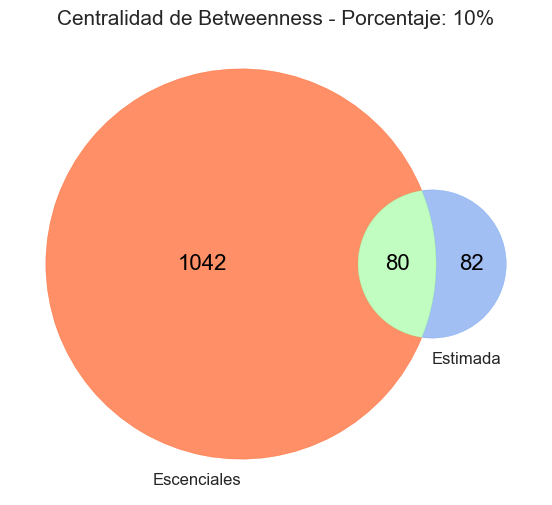

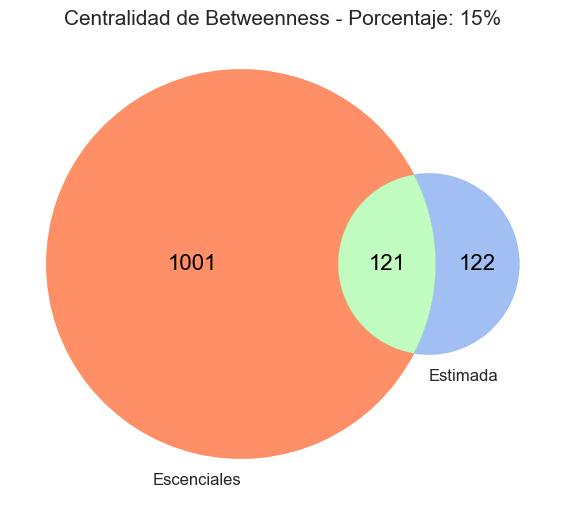

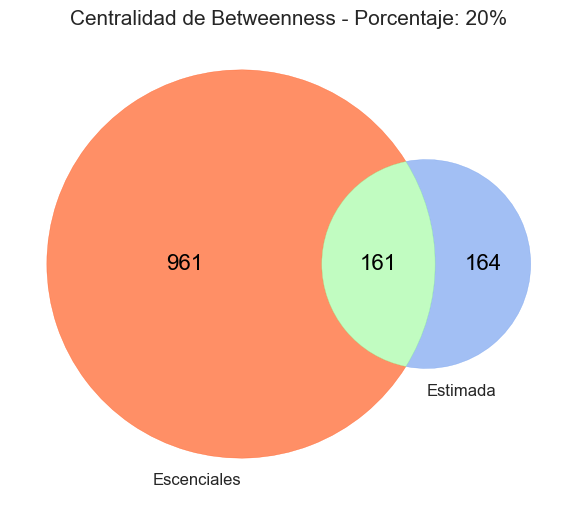

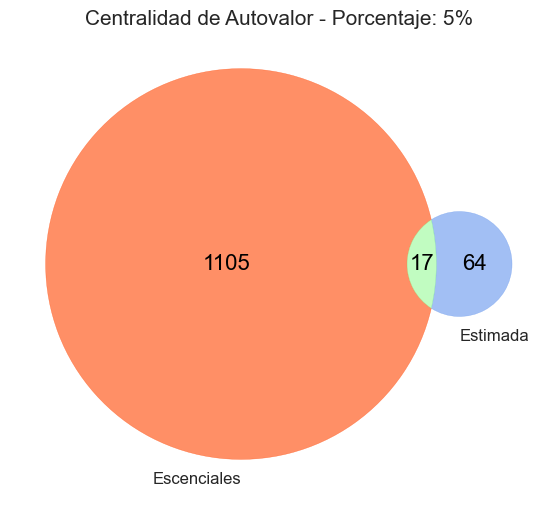

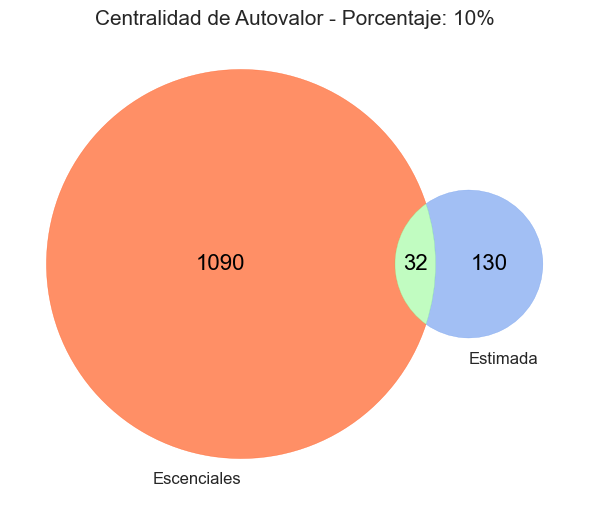

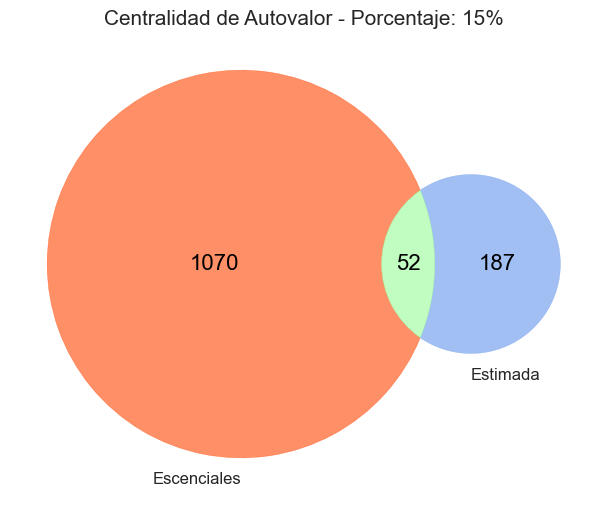

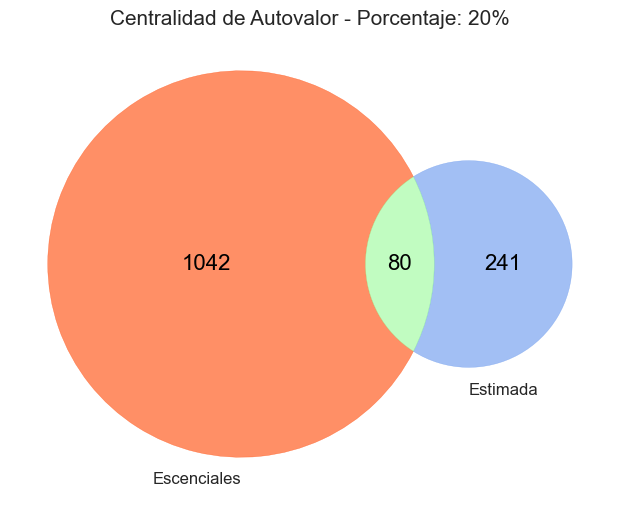

In [273]:
#lista_tabla_centralidades esta definido antes de los histogramas, se genera cuando hago 
porcentajes = np.arange(0.05, 0.2, 0.05)
centralidaddes = ['Grado', 'Cercanía', 'Betweenness', 'Autovalor']
indice_red = 3 #Sigue el orden de la lista de archivos lista_archivo

lista_nombres = ['APMS + C(0.6)', 'APMS + C(0.9)plus', 'C(0.9)', 'APMS']

for centralidad in centralidaddes:
	for por in porcentajes:
		salida = calcular_accuracy_javi(lista_tabla_centralidades[indice_red], lista_esenciales, por, calcular_porcentaje = 'standard')

		escenciales_estimado = list(salida[1][centralidad]['Nodo'])

		set1 = set(lista_esenciales)
		set2 = set(escenciales_estimado)

		plt.figure(figsize=(8, 6))
		venn = venn2([set1, set2], ('Escenciales', 'Estimada'))

		venn.get_patch_by_id('10').set_color('orangered')  # Color para el primer conjunto
		venn.get_patch_by_id('01').set_color('cornflowerblue')  # Color para el segundo conjunto
		venn.get_patch_by_id('11').set_color('palegreen')  # Color para la intersección

		for subset in ['10', '01', '11']:
			patch = venn.get_patch_by_id(subset)
			if patch: 
				patch.set_alpha(0.6)

		for subset in venn.subset_labels:
			if subset:
				subset.set_fontsize(16)
				subset.set_color('#000000')
		plt.title("Centralidad de " + centralidad + " - Porcentaje: " + str(int(por * 100)) + "%", fontsize = 15)
		plt.savefig('../../Graficos_ppt/venn/apms/venn_' + centralidad + '_' + str(int(por * 100)) + '-'+lista_nombres[indice_red]+'.png')

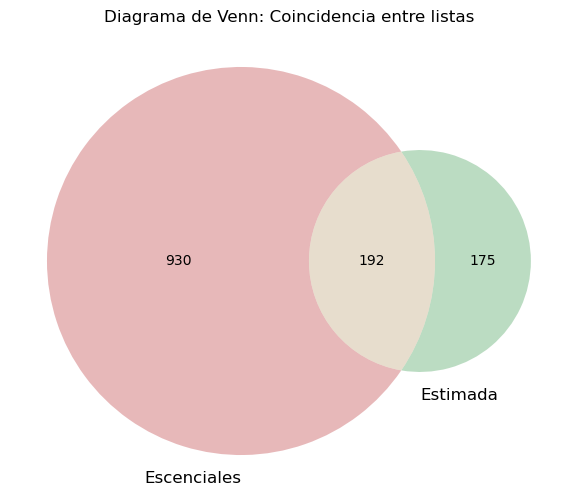

In [ ]:
# Crear conjuntos a partir de las listas
set1 = set(lista_esenciales)
set2 = set(escenciales_estimado)

# Crear el diagrama de Venn
plt.figure(figsize=(8, 6))
venn = venn2([set1, set2], ('Escenciales', 'Estimada'))

# Personalización opcional
plt.title("Centralidad de Grado")
plt.show()


In [183]:
# ## Quiero armar una matriz con los nodos esenciales y los nodos estimados, graficados en un heatmap donde la matriz a graficar sea lista_escenciales x lista_escenciales y 
# ## los valores sean 1 si el nodo esencial está en la lista estimada y 0 si no.

# matriz_lista = []
# for ke in salida[1].keys():
# 	print(ke)
# 	escenciales_estimado = list(salida[1][ke])
# 	matriz = np.zeros((len(lista_esenciales), len(escenciales_estimado)))

# 	for i in range(len(lista_esenciales)):
# 		for k in range(len(escenciales_estimado)):
# 			if escenciales_estimado[k] == lista_esenciales[i]:
# 				matriz[i, k] = 1
# 	matriz_lista.append(matriz)
	
# matriz_resultante = np.sum(matriz_lista, axis=0)

# matriz_resultante_normalizada = matriz_resultante.copy()
# matriz_resultante_normalizada[matriz_resultante_normalizada > 1] = 1

# plt.imshow(matriz_resultante_normalizada, cmap='seismic_r', aspect='auto')

# plt.xlabel('Nodos Estimados')
# plt.ylabel('Nodos Esenciales')

#### Metodo Javi

In [ ]:
porcentaje = np.arange(0.05, 0.2, 0.05)
metodo = 'javi'

configuraciones = [
    ('red_pesada_y2h-cota06.gpickle', '06entera/', 'Red 06'),
    ('red_pesada_y2h-cota09+full.gpickle', '09full/', 'Red 09+full'),
    ('red_pesada-0.9-sinAPMS.gpickle', '09siny2h/', 'Red 09 sin Y2H'),
    ('y2h.gpickle', 'y2h/', 'Red Y2H')
]

lista_tabla1, lista_tabla_centralidades, lista_accuracy_df, lista_precision = [], [], [], []

for archivo, path_suffix, categoria in configuraciones:
    print('Analizando archivo: ', archivo[:-8])
    path = f'../../Datos/subgrafos/y2h/{metodo}/{path_suffix}'
    
    tabla1, tabla_centralidades, accuracy_df, precision_df = funcion_analisis(archivo, path, resolucion=1, porcentaje=porcentaje, 
        																		metodo_porcentaje=metodo, comp_gigante=False)
    
    accuracy_df['Categoría'] = categoria
    precision_df['Categoría'] = categoria

    lista_tabla1.append(tabla1)
    lista_tabla_centralidades.append(tabla_centralidades)
    lista_accuracy_df.append(accuracy_df)
    lista_precision.append(precision_df)

df_final = pd.concat(lista_accuracy_df, ignore_index=True)[['Categoría', 'Porcentaje', 'Grado', 'Cercanía', 'Betweenness', 'Autovalor']]

df_final2 = pd.concat(lista_precision, ignore_index=True)[['Categoría', 'Porcentaje', 'Grado', 'Cercanía', 'Betweenness', 'Autovalor']]

categorias = df_final['Categoría'].unique()
porcentajes = df_final['Porcentaje'].unique()
metricas = ['Grado', 'Cercanía', 'Betweenness', 'Autovalor']


In [184]:
porcentaje = np.arange(0.05, 0.2, 0.05)
metodo = 'javi'

lista_archivo = ['red_pesada_y2h-cota06.gpickle', 'red_pesada_y2h-cota09+full.gpickle', 'red_pesada-0.9-sinAPMS.gpickle', 'y2h.gpickle']
lista_path = ['06entera/', '09full/', '09siny2h/', 'y2h/']

lista_tabla1, lista_tabla_centralidades, lista_accuracy_df, lista_precision = [], [], [], []

for i in range(len(lista_archivo)):
	print('Analizando archivo: ', lista_archivo[i][:-8])
	archivo = lista_archivo[i]
	path = '../../Datos/subgrafos/y2h/'+metodo+'/'+lista_path[i]
	tabla1, tabla_centralidades, accuracy_df, precision_df = funcion_analisis(archivo, path, resolucion = 1, porcentaje=porcentaje, metodo_porcentaje = metodo, comp_gigante = False)
	lista_tabla1.append(tabla1)
	lista_tabla_centralidades.append(tabla_centralidades)
	lista_accuracy_df.append(accuracy_df)
	lista_precision.append(precision_df)

lista_accuracy_df[0]['Categoría'] = 'Red 06'
lista_accuracy_df[1]['Categoría'] = 'Red 09+full'
lista_accuracy_df[2]['Categoría'] = 'Red 09 sin Y2H'
lista_accuracy_df[3]['Categoría'] = 'Red Y2H'

lista_precision[0]['Categoría'] = 'Red 06'
lista_precision[1]['Categoría'] = 'Red 09+full'
lista_precision[2]['Categoría'] = 'Red 09 sin Y2H'
lista_precision[3]['Categoría'] = 'Red Y2H'

df_final = pd.concat([lista_accuracy_df[0], lista_accuracy_df[1], lista_accuracy_df[2], lista_accuracy_df[3]], ignore_index=True)
df_final = df_final[['Categoría', 'Porcentaje', 'Grado', 'Cercanía', 'Betweenness', 'Autovalor']]

df_final2 = pd.concat([lista_precision[0], lista_precision[1], lista_precision[2], lista_precision[3]], ignore_index=True)
df_final2 = df_final2[['Categoría', 'Porcentaje', 'Grado', 'Cercanía', 'Betweenness', 'Autovalor']]

categorias = df_final['Categoría'].unique()
porcentajes = df_final['Porcentaje'].unique()

metricas = ['Grado', 'Cercanía', 'Betweenness', 'Autovalor']

Analizando archivo:  red_pesada_y2h-cota06
La cantidad de comunas que maximiza la modularidad es: 39
La modularidad de dicha partición es: 0.5172205299294096
Analizando archivo:  red_pesada_y2h-cota09+full
La cantidad de comunas que maximiza la modularidad es: 57
La modularidad de dicha partición es: 0.5361304913175418
Analizando archivo:  red_pesada-0.9-sinAPMS
La cantidad de comunas que maximiza la modularidad es: 4124
La modularidad de dicha partición es: 0.800573923014055
Analizando archivo:  y2h
La cantidad de comunas que maximiza la modularidad es: 38
La modularidad de dicha partición es: 0.5084072264457157


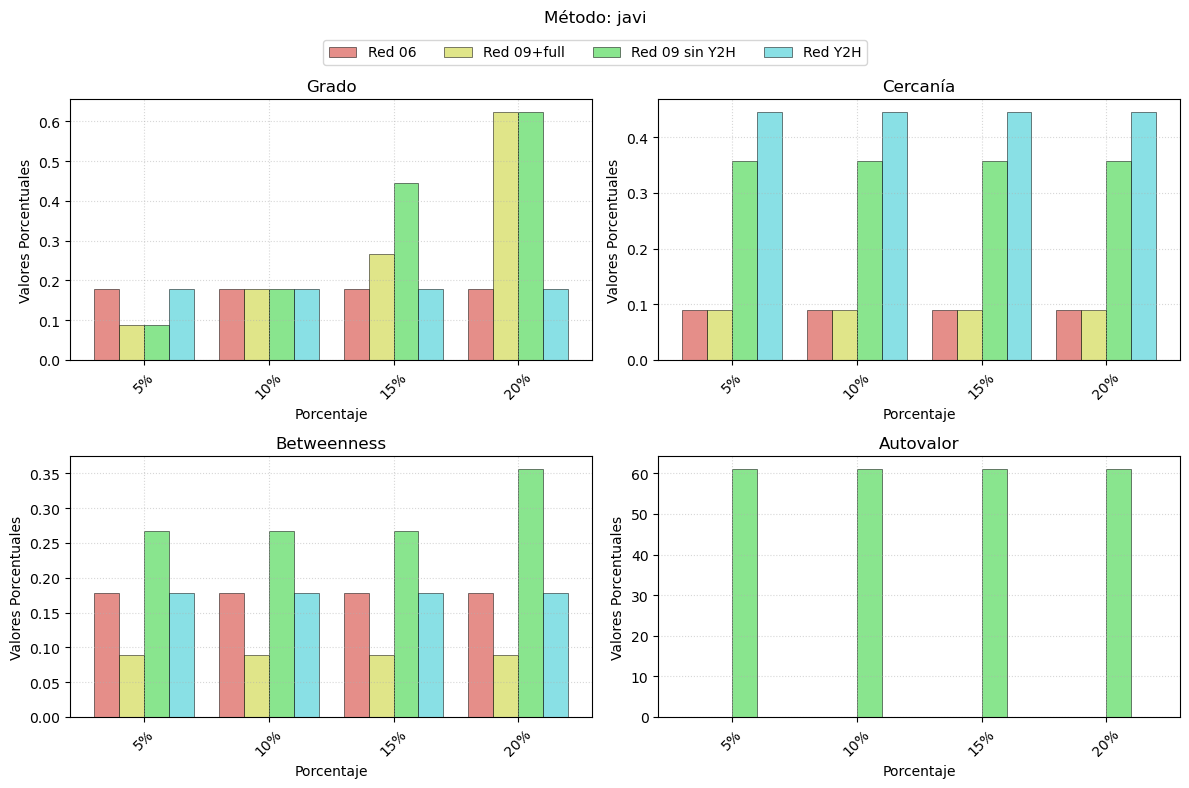

In [185]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))  

cantidad_porcentajes = 10  # Elegir cuántos porcentajes graficar 
porcentajes_seleccionados = porcentajes[:cantidad_porcentajes] 
x_posiciones = np.arange(len(porcentajes_seleccionados))
ancho_barra = 0.2


for k, metrica in enumerate(metricas):
    fila = k // 2
    columna = k % 2
    eje = ax[fila, columna]
    
    for i, categoria in enumerate(categorias):
        df_categoria = df_final[
            (df_final['Categoría'] == categoria) & 
            (df_final['Porcentaje'].isin(porcentajes_seleccionados))
        ]
        
        eje.bar(x_posiciones + i * ancho_barra, df_categoria[metrica].values, 
            width=ancho_barra, label=categoria, alpha=0.7, edgecolor='black', linewidth=0.5, color=sns.color_palette('hls')[i])
    
    eje.set_xticks(x_posiciones + (len(categorias) - 1) * ancho_barra / 2)
    eje.set_xticklabels(porcentajes_seleccionados, rotation=45)
    eje.set_xlabel('Porcentaje')
    eje.set_ylabel('Valores Porcentuales')
    eje.set_title(metrica)
    eje.grid(True, ls='dotted', alpha=0.5)

handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=len(categorias))

fig.suptitle('Método: ' +  metodo)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar el layout para evitar solapamientos


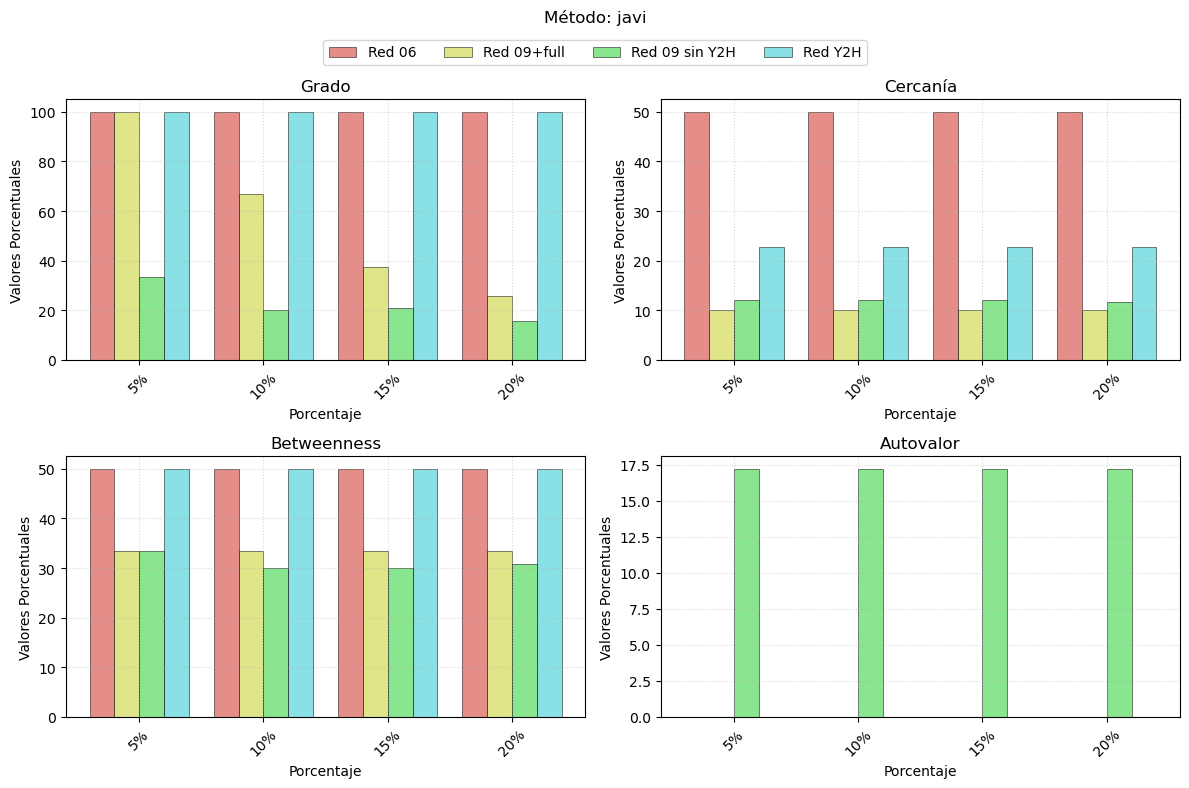

In [186]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))  

cantidad_porcentajes = 10  # Elegir cuántos porcentajes graficar 
porcentajes_seleccionados = porcentajes[:cantidad_porcentajes] 
x_posiciones = np.arange(len(porcentajes_seleccionados))
ancho_barra = 0.2


for k, metrica in enumerate(metricas):
    fila = k // 2
    columna = k % 2
    eje = ax[fila, columna]
    
    for i, categoria in enumerate(categorias):
        df_categoria = df_final2[
            (df_final2['Categoría'] == categoria) & 
            (df_final2['Porcentaje'].isin(porcentajes_seleccionados))
        ]
        
        eje.bar(x_posiciones + i * ancho_barra, df_categoria[metrica].values, 
            width=ancho_barra, label=categoria, alpha=0.7, edgecolor='black', linewidth=0.5, color=sns.color_palette('hls')[i])
    
    eje.set_xticks(x_posiciones + (len(categorias) - 1) * ancho_barra / 2)
    eje.set_xticklabels(porcentajes_seleccionados, rotation=45)
    eje.set_xlabel('Porcentaje')
    eje.set_ylabel('Valores Porcentuales')
    eje.set_title(metrica)
    eje.grid(True, ls='dotted', alpha=0.5)

handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=len(categorias))

fig.suptitle('Método: ' +  metodo)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar el layout para evitar solapamientos

# Quiero repetir pero para apms

In [187]:
porcentaje = np.arange(0.05, 0.2, 0.05)
metodo = 'standard'

# Definimos las configuraciones como listas de tuplas
configuraciones = [
    ('red_pesada-cota06.gpickle', '06entera/', 'Red 06'),
    ('red_pesada-cota09+full.gpickle', '09full/', 'Red 09+full'),
    ('red_pesada-0.9-sinAPMS.gpickle', '09sinapms/', 'Red 09 sin apms'),
    ('apms.gpickle', 'apms/', 'Red APMS')
]

# Inicializamos las listas para almacenar resultados
lista_tabla1, lista_tabla_centralidades, lista_accuracy_df, lista_precision = [], [], [], []

# Iteramos sobre las configuraciones
for archivo, path_suffix, categoria in configuraciones:
    print('Analizando archivo: ', archivo[:-8])
    path = f'../../Datos/subgrafos/apms/{metodo}/{path_suffix}'
    
    # Llamada a la función de análisis
    tabla1, tabla_centralidades, accuracy_df, precision_df = funcion_analisis(
        archivo, path, resolucion=1, porcentaje=porcentaje, 
        metodo_porcentaje=metodo, comp_gigante=False
    )
    
    # Agregamos la categoría a los DataFrames
    accuracy_df['Categoría'] = categoria
    precision_df['Categoría'] = categoria

    # Almacenamos resultados
    lista_tabla1.append(tabla1)
    lista_tabla_centralidades.append(tabla_centralidades)
    lista_accuracy_df.append(accuracy_df)
    lista_precision.append(precision_df)

# Concatenamos y seleccionamos columnas relevantes
df_final = pd.concat(lista_accuracy_df, ignore_index=True)[
    ['Categoría', 'Porcentaje', 'Grado', 'Cercanía', 'Betweenness', 'Autovalor']
]

df_final2 = pd.concat(lista_precision, ignore_index=True)[
    ['Categoría', 'Porcentaje', 'Grado', 'Cercanía', 'Betweenness', 'Autovalor']
]

# Obtenemos categorías y porcentajes únicos
categorias = df_final['Categoría'].unique()
porcentajes = df_final['Porcentaje'].unique()
metricas = ['Grado', 'Cercanía', 'Betweenness', 'Autovalor']


Analizando archivo:  red_pesada-cota06
La cantidad de comunas que maximiza la modularidad es: 213
La modularidad de dicha partición es: 0.7897459195891352
Analizando archivo:  red_pesada-cota09+full
La cantidad de comunas que maximiza la modularidad es: 177
La modularidad de dicha partición es: 0.8000589524520088
Analizando archivo:  red_pesada-0.9-sinAPMS
La cantidad de comunas que maximiza la modularidad es: 4123
La modularidad de dicha partición es: 0.8046096463456129
Analizando archivo:  apms
La cantidad de comunas que maximiza la modularidad es: 215
La modularidad de dicha partición es: 0.7770570133799429


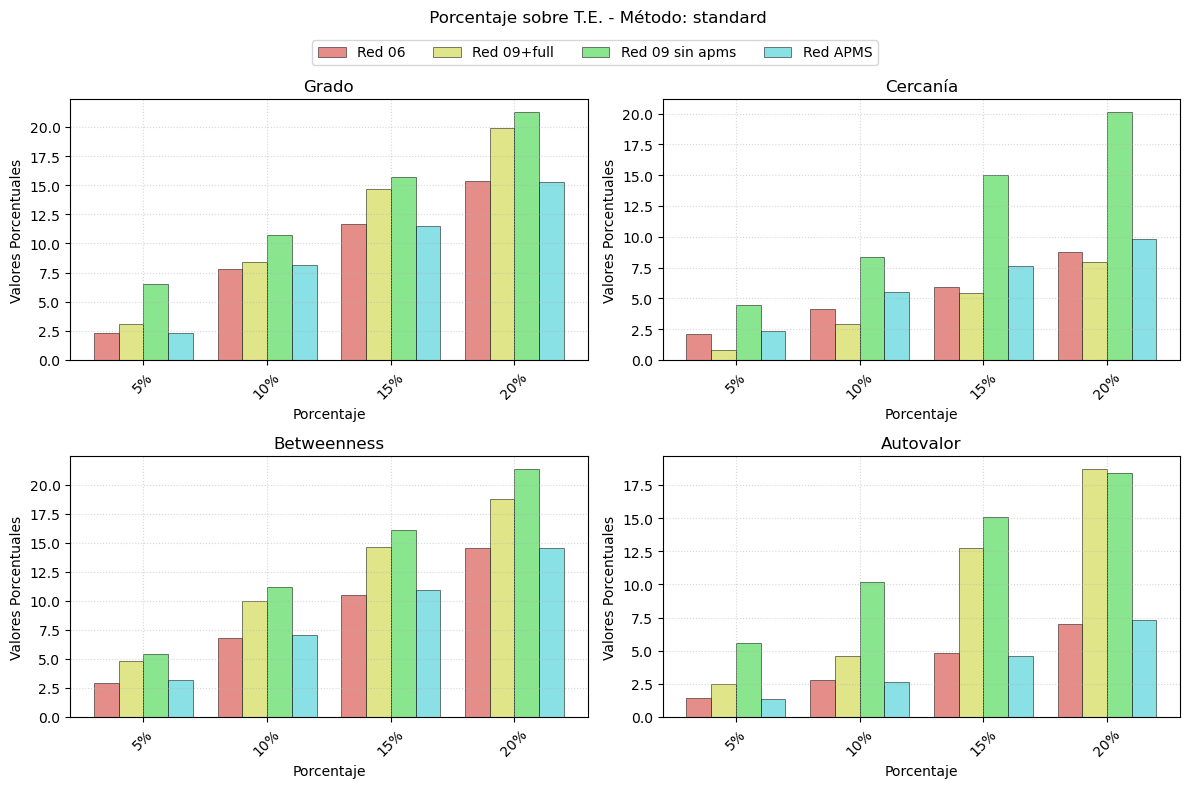

In [190]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))  

cantidad_porcentajes = 10  # Elegir cuántos porcentajes graficar 
porcentajes_seleccionados = porcentajes[:cantidad_porcentajes] 
x_posiciones = np.arange(len(porcentajes_seleccionados))
ancho_barra = 0.2


for k, metrica in enumerate(metricas):
    fila = k // 2
    columna = k % 2
    eje = ax[fila, columna]
    
    for i, categoria in enumerate(categorias):
        df_categoria = df_final[
            (df_final['Categoría'] == categoria) & 
            (df_final['Porcentaje'].isin(porcentajes_seleccionados))
        ]
        
        eje.bar(x_posiciones + i * ancho_barra, df_categoria[metrica].values, 
            width=ancho_barra, label=categoria, alpha=0.7, edgecolor='black', linewidth=0.5, color=sns.color_palette('hls')[i])
    
    eje.set_xticks(x_posiciones + (len(categorias) - 1) * ancho_barra / 2)
    eje.set_xticklabels(porcentajes_seleccionados, rotation=45)
    eje.set_xlabel('Porcentaje')
    eje.set_ylabel('Valores Porcentuales')
    eje.set_title(metrica)
    eje.grid(True, ls='dotted', alpha=0.5)

handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=len(categorias))

fig.suptitle(' Porcentaje sobre T.E. - Método: ' +  metodo)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar el layout para evitar solapamientos

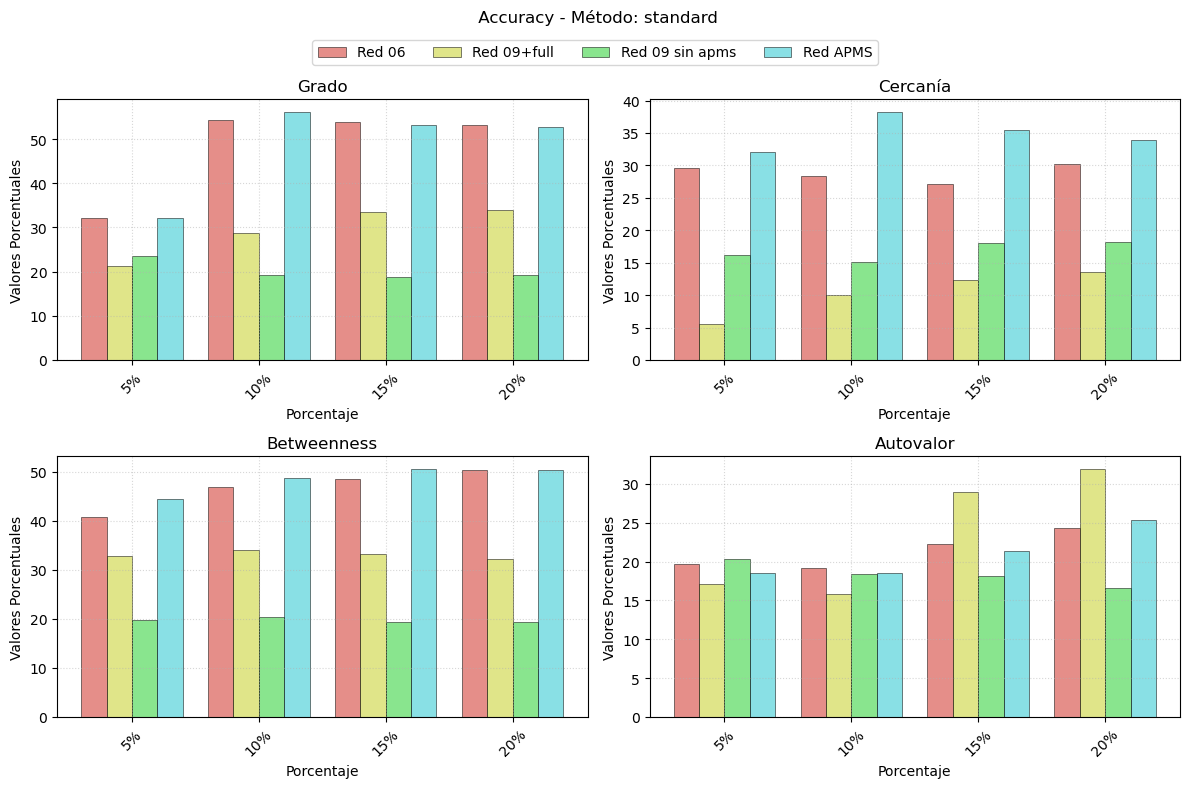

In [191]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))  

cantidad_porcentajes = 10  # Elegir cuántos porcentajes graficar 
porcentajes_seleccionados = porcentajes[:cantidad_porcentajes] 
x_posiciones = np.arange(len(porcentajes_seleccionados))
ancho_barra = 0.2


for k, metrica in enumerate(metricas):
    fila = k // 2
    columna = k % 2
    eje = ax[fila, columna]
    
    for i, categoria in enumerate(categorias):
        df_categoria = df_final2[
            (df_final2['Categoría'] == categoria) & 
            (df_final2['Porcentaje'].isin(porcentajes_seleccionados))
        ]
        
        eje.bar(x_posiciones + i * ancho_barra, df_categoria[metrica].values, 
            width=ancho_barra, label=categoria, alpha=0.7, edgecolor='black', linewidth=0.5, color=sns.color_palette('hls')[i])
    
    eje.set_xticks(x_posiciones + (len(categorias) - 1) * ancho_barra / 2)
    eje.set_xticklabels(porcentajes_seleccionados, rotation=45)
    eje.set_xlabel('Porcentaje')
    eje.set_ylabel('Valores Porcentuales')
    eje.set_title(metrica)
    eje.grid(True, ls='dotted', alpha=0.5)

handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=len(categorias))

fig.suptitle(' Accuracy - Método: ' +  metodo)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar el layout para evitar solapamientos